Necessary imports

In [2]:
import tensorflow as tf
from re import split
import os
import urllib
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import argparse
from tensorflow.keras.layers import BatchNormalization, Reshape, Conv2DTranspose, Flatten, Conv2D, Dense, Dropout

# Preparing the data

In [3]:
# loading the dataset
def load_data():
    """
    Loading the data set directly from google
        Returns:
            data: processed dataset
    """

    # load images restricted to one category (candles)
    categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
    category = 'candle'

    # Creates a folder to download the original drawings into.
    if not os.path.isdir('npy_files'):
        os.mkdir('npy_files')

    url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'
    urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

    images = np.load(f'npy_files/{category}.npy')
    print(f'{len(images)} images to train on')

    train_imgs = images[:30000]
    valid_imgs = images[30000:40000]
    test_imgs = images[40000:50000]

    train_ds = tf.data.Dataset.from_tensor_slices(train_imgs)
    valid_ds = tf.data.Dataset.from_tensor_slices(valid_imgs)
    test_ds = tf.data.Dataset.from_tensor_slices(test_imgs)
    
    # performing preprocessing steps
    train_ds = data_pipeline(train_ds)
    valid_ds = data_pipeline(valid_ds)
    test_ds = data_pipeline(test_ds)

    return train_ds, valid_ds, test_ds

def data_pipeline(data):
    """ Describtion here
    Args:
        data:
    Return:
        data:
    """
    # casting and reshaping
    data = data.map(lambda image: (tf.cast(image, tf.float32)))
    data = data.map(lambda image: (tf.reshape(image,[28,28,1])))
    # normalization, brings image values from range [0, 255] to [-1, 1]
    data = data.map(lambda image: ((image/128)-1))

    #cache progress in memory, as there is no need to redo it
    data = data.cache()

    #shuffle, batch, prefetch
    data = data.shuffle(2000)
    data = data.batch(64)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

# GAN Model

Discriminator

In [4]:
class Descriminator(tf.keras.Model):

    def __init__(self):
        super(Descriminator, self).__init__()

        self._conv1 = Conv2D(filters=64, kernel_size=5, strides=2, padding="same")
        self._drop1 = Dropout(0.3)

        self._conv2 = Conv2D(filters=128, kernel_size=5, strides=2, padding="same")
        self._drop2 = Dropout(0.3)

        self._flatten = Flatten()
        self._dense = Dense(1)

    def call(self, x, for_training=None):

        x = self._conv1(x, training=for_training)
        x = tf.nn.leaky_relu(x)
        x = self._drop1(x, training=for_training)

        x = self._conv2(x, training=for_training)
        x = tf.nn.leaky_relu(x)
        x = self._drop2(x, training=for_training)

        x = self._flatten(x, training=for_training)
        x = self._dense(x, training=for_training)
        
        return x

Generator

In [5]:
class Generator(tf.keras.Model):

    def __init__(self):
        super(Generator, self).__init__()

        self._dense = Dense(7*7*8)

        self._bn1 = BatchNormalization()
        self._convt1 = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding="same")

        self._bn2 = BatchNormalization()
        self._convt2 = Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding="same")

        self._bn3 = BatchNormalization()
        self._out = Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding="same", activation="tanh")

    def call(self, x, for_training=None):
        x = self._dense(x, training=for_training)

        x = self._bn1(x, training=for_training)
        x = tf.nn.leaky_relu(x)
        x = tf.reshape(x, (64,7,7,8))
        x = self._convt1(x, training=for_training)

        x = self._bn2(x, training=for_training)
        x = tf.nn.leaky_relu(x)
        x = self._convt2(x, training=for_training)
        
        x = self._bn3(x, training=for_training)
        x = tf.nn.leaky_relu(x)

        x = self._out(x, training=for_training)

        return x

# Training

In [6]:
def train_step(g, d, imgs, loss_function, g_optim, d_optim, for_training):
    # generates a random image
    noise = tf.random.normal([64,100])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

        # generate noise vector
        generated_imgs = g(noise, training=for_training)

        real_out = d(imgs, training=for_training)
        fake_out = d(generated_imgs, training=for_training)

        # calculating losses
        g_loss = loss_function(tf.ones_like(fake_out), fake_out)
        d_loss = loss_function(tf.ones_like(real_out)*0.9, real_out) + loss_function(tf.zeros_like(fake_out), fake_out)

        # calculaing the gradients
        gradients_g = g_tape.gradient(g_loss, g.trainable_variables)
        gradients_d = d_tape.gradient(d_loss, d.trainable_variables)

    # updating weights and biases
    g_optim.apply_gradients(zip(gradients_g, g.trainable_variables))
    d_optim.apply_gradients(zip(gradients_d, d.trainable_variables))

    return g_loss, d_loss


def test(gen, disc, test_data, loss_function, for_training):
    # initializing lists for accuracys and loss
    accuracy_aggregator = []
    g_loss_aggregator = []
    d_loss_aggregator = []

    for imgs in test_data:
        # forward step
        noise = tf.random.normal([64,100])
        generated_imgs = g(noise, training=for_training)
        real_out = d(imgs, training=for_training)
        fake_out = d(generated_imgs, training=for_training)

        # calculating loss
        g_loss = loss_function(tf.ones_like(fake_out), fake_out)
        d_loss = loss_function(tf.ones_like(real_out)*0.9, real_out) + loss_function(tf.zeros_like(fake_out)*0.95, fake_out)

        # add loss and accuracy to the lists
        g_loss_aggregator.append(g_loss.numpy())
        d_loss_aggregator.append(d_loss.numpy())

    # calculate the mean of the loss and accuracy (for this epoch)
    g_loss = tf.reduce_mean(g_loss_aggregator)
    d_loss = tf.reduce_mean(d_loss_aggregator)

    return g_loss, d_loss


In [7]:
def classification(g, d, num_epochs, train_ds, valid_ds):
    seed = tf.random.normal([64,100])
    tf.keras.backend.clear_session()

    # initialize the loss: categorical cross entropy
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    lr = 0.0002

    # optimizers for both models
    g_optim = tf.keras.optimizers.Adam(lr,beta_1=0.5)
    d_optim = tf.keras.optimizers.Adam(lr,beta_1=0.5)

    # initialize lists for later visualization.
    train_g_losses = []
    valid_g_losses = []
    train_d_losses = []
    valid_d_losses = []

    # testing on our valid_ds once before we begin
    valid_g_loss, valid_d_loss = test(g, d, valid_ds, loss, for_training=False)
    valid_g_losses.append(valid_g_loss)
    valid_d_losses.append(valid_d_loss)

    # Testing on our train_ds once before we begin
    train_g_loss, train_d_loss = test(g, d, train_ds, loss, for_training=False)
    train_g_losses.append(train_g_loss)
    train_d_losses.append(train_d_loss)

    # training our model for num_epochs epochs
    for epoch in range(num_epochs):
        print(f' starting with (validation set): g_loss {valid_g_losses[-1]} and d_loss {valid_d_losses[-1]}')
        print(f' and (training set): g_loss {train_g_losses[-1]} and d_loss {train_d_losses[-1]}')
        print("{}/{} epoches".format(epoch, num_epochs))
        
        # training (and calculating loss while training)
        epoch_g_loss_agg = []
        epoch_d_loss_agg = []

        for imgs in train_ds:
            train_g_loss, train_d_loss = train_step(g, d, imgs, loss, g_optim, d_optim, for_training=True)
            epoch_g_loss_agg.append(train_g_loss)
            epoch_d_loss_agg.append(train_d_loss)

        # track training loss
        train_g_losses.append(tf.reduce_mean(epoch_g_loss_agg))
        train_d_losses.append(tf.reduce_mean(epoch_d_loss_agg))

        ## After i-th epoch plot image
        if (epoch % 5) == 0:
            fake_image = tf.reshape(g(seed, for_training=False), shape = (64,28,28))
            plt.imshow(fake_image[10], cmap = "gray")
            plt.show()

        # testing our model in each epoch to track accuracy and loss on the validation set
        valid_g_loss, valid_d_loss = test(g, d, valid_ds, loss, for_training=False)
        valid_g_losses.append(valid_g_loss)
        valid_d_losses.append(valid_d_loss)

    results = [train_g_losses, valid_g_losses, train_d_losses, valid_d_losses]
    return results, g, d

In [8]:
def visualize_results(train_g_losses, valid_g_losses, train_d_losses, valid_d_losses):

    fig, axs = plt.subplots(2, 1)
    #fig.set_size_inches(13, 6)
    # making a grid with subplots
    for j in range(1):
        axs[0].plot(train_g_l[j])
        axs[0].plot(valid_g_l[j])
        axs[1].plot(train_d_l[j])
        axs[1].plot(valid_d_l[j])
        axs[1].sharex(axs[0])

    fig.legend([" train_g_l"," valid_g_l"," train_d_l"," valid_d_l"],loc="lower right")
    plt.xlabel("Training epoch")
    fig.tight_layout()
    plt.show()

141545 images to train on
 starting with (validation set): g_loss 0.6924867033958435 and d_loss 1.3940385580062866
 and (training set): g_loss 0.6924607157707214 and d_loss 1.3942387104034424
0/10 epoches


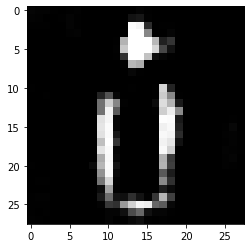

 starting with (validation set): g_loss 1.070691466331482 and d_loss 1.086503505706787
 and (training set): g_loss 0.9579606652259827 and d_loss 1.196457028388977
1/10 epoches
 starting with (validation set): g_loss 1.1470497846603394 and d_loss 1.0514775514602661
 and (training set): g_loss 1.0479917526245117 and d_loss 1.1837100982666016
2/10 epoches


In [ ]:
tf.keras.backend.clear_session()
train_ds, valid_ds, test_ds = load_data()

d = Descriminator()
g = Generator()

train_g_losses = []
valid_g_losses = []
train_d_losses = []
valid_d_losses = []


with tf.device('/device:gpu:0'):
    # training the model
    results, trained_g, trained_d = classification(g, d, 10, train_ds, valid_ds)

    # saving results for visualization
    train_g_losses.append(results[0])
    valid_g_losses.append(results[1])
    train_d_losses.append(results[2])
    valid_d_losses.append(results[3])

    # testing the trained model
    _, test_accuracy = test(trained_model, test_ds, tf.keras.losses.BinaryCrossentropy(), False)
    print("Accuracy (test set):", test_accuracy)

# visualizing losses and accuracy
visualize_results(train_g_losses, valid_g_losses, train_d_losses, valid_d_losses)